In [1]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import pickle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Load and unzip taxidata

In [2]:
def load_taxi_data():
    download_file_name = "nyc-taxi-trip-duration.zip"
    data_dir = Path("data_packages")
    extracted_dir = Path("data")
    csv_path = extracted_dir / "train.csv"
    pkl_path = extracted_dir / "train.pkl"

    zip_path = data_dir / download_file_name

    # Schritt 0: Schneller CSV-Zugriff über Cache (falls vorhanden)
    if pkl_path.is_file():
        with open(pkl_path, "rb") as f:
            return pickle.load(f)

    # Schritt 1: Download nur wenn ZIP noch fehlt
    if not zip_path.is_file():
        data_dir.mkdir(parents=True, exist_ok=True)
        api = KaggleApi()
        api.authenticate()
        api.competition_download_files("nyc-taxi-trip-duration", path=data_dir)

    # Schritt 2: Entpacke ZIP nur, wenn innere ZIPs fehlen
    inner_zip_names = {"train.zip", "test.zip", "sample_submission.zip"}
    existing_inner_zips = {z.name for z in data_dir.glob("*.zip")}
    missing_inner_zips = inner_zip_names - existing_inner_zips

    if missing_inner_zips:
        with ZipFile(zip_path, 'r') as outer_zip:
            outer_zip.extractall(data_dir)

    # Schritt 3: Entpacke nur fehlende CSVs aus inneren ZIPs
    extracted_dir.mkdir(parents=True, exist_ok=True)
    for inner_zip in data_dir.glob("*.zip"):
        with ZipFile(inner_zip, 'r') as zip_ref:
            for member in zip_ref.namelist():
                if member.endswith(".csv"):
                    target_file = extracted_dir / Path(member).name
                    if not target_file.is_file():
                        zip_ref.extract(member, path=extracted_dir)

    # Schritt 4: CSV laden und pkl-Cache speichern
    if not csv_path.is_file():
        raise FileNotFoundError(f"'{csv_path}' wurde nicht gefunden – Entpackung fehlgeschlagen.")

    df = pd.read_csv(csv_path)
    with open(pkl_path, "wb") as f:
        pickle.dump(df, f)

    return df

# Anwendung
taxi = load_taxi_data()

Explore taxi data

In [3]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Show Column info

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- pickup_datetime and dropoff_datetime should be converted into data type of "date"

transform pickup_datetime and dropoff_datetime into datetime64

In [5]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])

taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


Check store_and_fwd_flag

In [6]:
taxi["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

- This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

Show Overview of numerical variables

In [7]:
taxi.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,2016-01-01 00:03:31,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,2016-04-01 17:35:12,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,2016-07-01 23:02:03,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


Plot data in hist

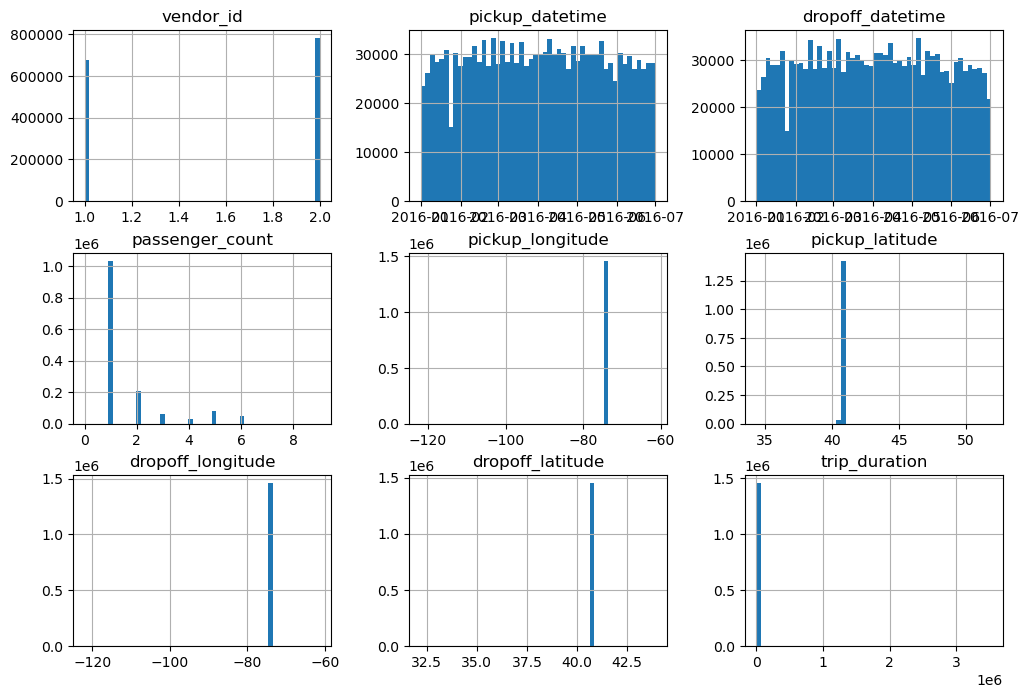

In [8]:
taxi.hist(bins=50, figsize=(12, 8))
plt.show()

- Some data is concentrated in certain intervalls. Maybe data needs to be categorized.

## Create Testdata

Don't look into test data - Data-Snooping-Bias

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(taxi, test_size=0.3, random_state=42)